In [2]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, GroupedLayerControl
import ast
import seaborn as sns
from scipy.optimize import curve_fit

from data_utilities import *

## Regression

In [3]:
# TODO: find regression with every category of service
def make_df(services_filter: list = []):

    data = pd.DataFrame()
    if len(services_filter) != 0:
        for i in range(len(services_filter)):
            if type(services_filter[i]) != str:
                services_filter[i] = services[services_filter[i]]
        for i in services_filter:
            # data = DF[DF["Service Area and Request"].isin(services_filter)]
            data = DF[DF["Service Request"].isin(services_filter)]
    else:
        data = DF

    census_df = pd.read_csv("./assets/census_2016_new.csv")
    census_df = census_df[census_df["Boundary Type"] == "Neighbourhood"]

    # combined_df = pd.merge(DF, census_df, left_on="Neighbourhood", right_on="Boundary Name", how="inner")
    combined_df = data.groupby("Neighbourhood").size().sort_values().to_frame().rename(columns={0: "Count"})
    combined_df = pd.merge(combined_df, census_df, left_on="Neighbourhood", right_on="Boundary Name", how="inner")

    return combined_df[combined_df['Population 2016'] != 0]

combined_df = make_df()

In [18]:
def plot_regression(x:str, y:str, data, xlables:str="", ylables:str="", xunit:str="", yunit:str="", xpercent:bool=False, ypercent:bool=False) -> tuple[float, float, float]:
    if xpercent:
        data[x] *= 100
        xunit = "Percent"
    if ypercent:
        data[y] *= 100
        yunit = "Percent"
    ci = sns.lmplot(x=x, y=y, data=data)
    if xlables == "":
        xlables = x
    if ylables == "":
        ylables = y
    if xunit != "":
        xunit = " (" + xunit + ")"
    if yunit != "":
        yunit = " (" + yunit + ")"
    ci.set(xlabel=xlables + xunit)
    ci.set(ylabel=ylables + yunit)
    plt.show()
    slope, intercept = np.polyfit(data[x], data[y], 1)
    conf_int = float(np.mean(np.array(ci.ax.lines[0].get_ydata())))
    if xpercent:
        data[x] /= 100
    if ypercent:
        data[y] /= 100
    return slope, intercept, conf_int


In [41]:
combined_df['Average Household Income'] = combined_df['Average and Median Household Income'].str.strip("[]").str.split(', ').str[0]
combined_df['Median Household Income'] = combined_df['Average and Median Household Income'].str.strip("[]").str.split(', ').str[1]
combined_df['Average Household Income']= combined_df['Average Household Income'].astype(int)
combined_df['Median Household Income']= combined_df['Median Household Income'].astype(int)

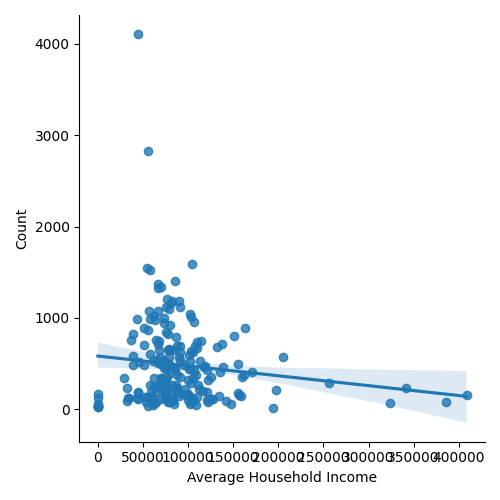

In [112]:
# combined_df.plot(kind="scatter", x="Average Household Income", y="Count")
sns.lmplot(x="Average Household Income", y="Count", data=combined_df)
plt.show()

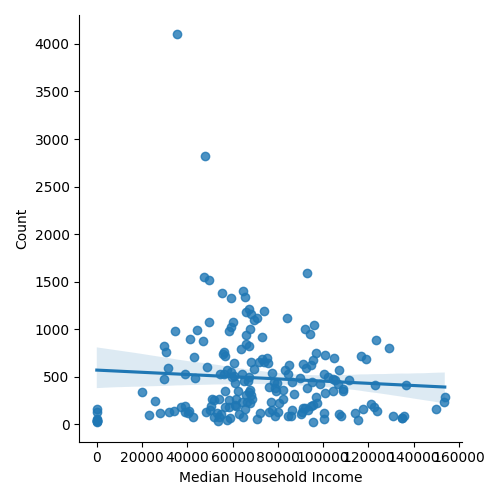

In [113]:
# combined_df.plot(kind="scatter", x="Median Household Income", y="Count")
sns.lmplot(x="Median Household Income", y="Count", data=combined_df)
plt.show()

Income doesn't seem to be a good predictor of the number of events.

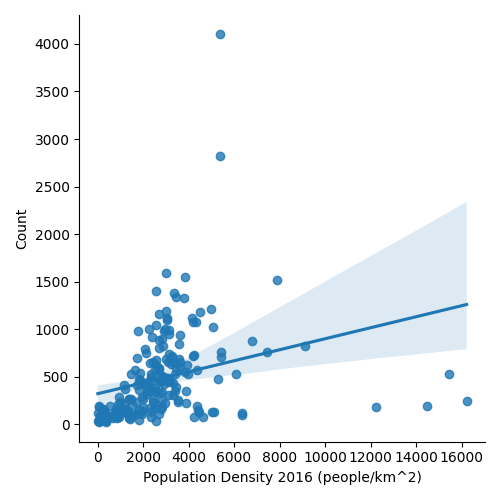

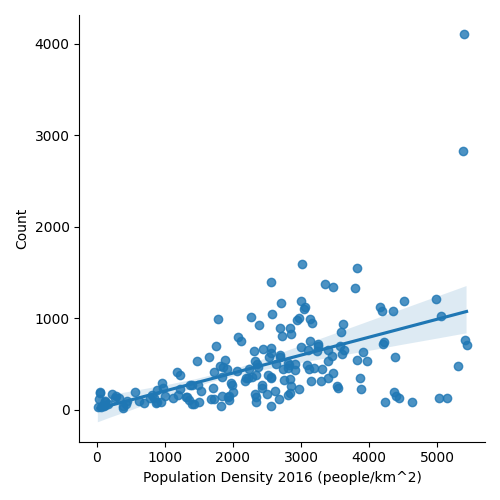

In [114]:
ci1 = sns.lmplot(x="Population Density 2016", y="Count", data=combined_df)
ci1.set_xlabels("Population Density 2016 (people/km^2)")
plt.show()
ci2 = sns.lmplot(x="Population Density 2016", y="Count", data=combined_df[combined_df["Population Density 2016"] < 6000])
ci2.set_xlabels("Population Density 2016 (people/km^2)")
plt.show()
# ci3 = sns.lmplot(x="Population Density 2016", y="Count", data=combined_df[combined_df["Apartment"]<combined_df['House']])
# plt.show()

In [115]:
np.sum(combined_df[combined_df['Population Density 2016']>12000][combined_df['Count']< 700]['Count'])

C:\Users\tommy\AppData\Local\Temp\ipykernel_22896\3468294994.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.sum(combined_df[combined_df['Population Density 2016']>12000][combined_df['Count']< 700]['Count'])


1134

In [116]:
slope1, intercept1 = np.polyfit(combined_df["Population Density 2016"], combined_df["Count"], 1)
slope2, intercept2 = np.polyfit(combined_df[combined_df["Population Density 2016"] < 6000]["Population Density 2016"], combined_df[combined_df["Population Density 2016"] < 6000]["Count"], 1)
# slope3, intercept3 = np.polyfit(combined_df[combined_df["Apartment"]<combined_df['House']]["Population Density 2016"], combined_df[combined_df["Apartment"]<combined_df['House']]["Count"], 1)
conf_int1 = np.mean(np.array(ci1.ax.lines[0].get_ydata()))
conf_int2 = np.mean(np.array(ci2.ax.lines[0].get_ydata()))
# conf_int3 = np.mean(np.array(ci3.ax.lines[0].get_ydata()))

There's a positive correlation between population density and number of events.

In [117]:
combined_df[combined_df["Population Density 2016"] > 6000]

,Count,Boundary Type,Boundary Name,Population 2016,Population Density 2016,Year opened,Aboriginal,Aboriginal Percent,Visible Minorities Numbers,Visible Minorities Percent,...,Own vs Rent Percent,Bad Dwelling,Bad Dwelling Percent,Average and Median Household Income,Commuting Method,Commuting Method Percent,LIM-AT,LICO-AT,Average Household Income,Median Household Income
62,94,Neighbourhood,China Town,420,6364.311366,1986,0,0.000000,"[25, 30, 0, 310, 15, 0, 25, 0, 0, 0, 0, 0]","[0.06172839506172839, 0.07407407407407407, 0, ...",...,"[0, 1]",15,0.081081,"[32142, 22886]","[35, 85]","[0.2916666666666667, 0.7083333333333334]",0.571429,0.321429,32142,22886
69,119,Neighbourhood,Portage-Ellice,1075,6343.268170,2001,120,0.111628,"[70, 110, 65, 90, 10, 0, 30, 10, 0, 0, 10, 0]","[0.17721518987341772, 0.27848101265822783, 0.1...",...,"[0.058394160583941604, 0.9416058394160584]",35,0.051095,"[44469, 40481]","[115, 295]","[0.2804878048780488, 0.7195121951219512]",0.242991,0.228972,44469,40481
98,182,Neighbourhood,Alpine Place,3895,12236.883443,1971,475,0.121951,"[145, 260, 630, 15, 0, 35, 35, 15, 10, 0, 10, 50]","[0.12033195020746888, 0.2157676348547718, 0.52...",...,"[0.03991130820399113, 0.9600886917960089]",160,0.070953,"[44114, 37015]","[855, 575]","[0.5979020979020979, 0.40209790209790214]",0.311938,0.243902,44114,37015
102,188,Neighbourhood,Roslyn,4550,14491.045808,1971,235,0.051648,"[50, 135, 90, 90, 30, 85, 10, 40, 30, 0, 10, 15]","[0.08547008547008547, 0.23076923076923078, 0.1...",...,"[0.3697068403908795, 0.6302931596091205]",225,0.073290,"[88912, 61605]","[1415, 990]","[0.5883575883575883, 0.41164241164241167]",0.135165,0.119780,88912,61605
115,240,Neighbourhood,Central Park,3775,16221.907095,2001,675,0.178808,"[850, 185, 1065, 115, 105, 35, 10, 10, 30, 10,...","[0.34, 0.074, 0.426, 0.046, 0.042, 0.014, 0.00...",...,"[0.11023622047244094, 0.889763779527559]",190,0.099738,"[32248, 25574]","[435, 930]","[0.31868131868131866, 0.6813186813186812]",0.543046,0.475497,32248,25574
164,524,Neighbourhood,Broadway-Assiniboine,5270,15452.189109,1981,720,0.136622,"[340, 205, 505, 160, 25, 185, 45, 30, 55, 10, ...","[0.2118380062305296, 0.1277258566978193, 0.314...",...,"[0.06721536351165981, 0.9327846364883402]",345,0.094521,"[45656, 38847]","[930, 2135]","[0.3034257748776509, 0.6965742251223491]",0.313390,0.275404,45656,38847
165,525,Neighbourhood,Mcmillan,3445,6074.487856,1971,375,0.108853,"[70, 95, 60, 60, 10, 50, 10, 20, 20, 25, 10, 10]","[0.1590909090909091, 0.2159090909090909, 0.136...",...,"[0.31592039800995025, 0.6840796019900498]",265,0.131841,"[72318, 54548]","[1250, 1120]","[0.5274261603375527, 0.4725738396624472]",0.172714,0.200290,72318,54548
199,763,Neighbourhood,West Broadway,5010,7429.442540,1971,1160,0.231537,"[135, 110, 570, 65, 40, 60, 135, 95, 0, 0, 20,...","[0.10887096774193548, 0.08870967741935484, 0.4...",...,"[0.08445945945945946, 0.9155405405405406]",405,0.136824,"[37279, 30527]","[910, 1710]","[0.3473282442748092, 0.6526717557251908]",0.466068,0.430140,37279,30527
203,828,Neighbourhood,Spence,4415,9125.954711,1971,1210,0.274066,"[705, 160, 730, 185, 140, 45, 45, 20, 10, 10, ...","[0.3271461716937355, 0.07424593967517401, 0.33...",...,"[0.1745635910224439, 0.8254364089775561]",245,0.122195,"[38787, 29675]","[530, 1035]","[0.33865814696485624, 0.6613418530351437]",0.524349,0.462061,38787,29675
205,871,Neighbourhood,St. Matthews,5770,6774.256417,1971,1110,0.192374,"[1465, 130, 530, 160, 300, 80, 50, 10, 0, 10, ...","[0.5034364261168385, 0.044673539518900345, 0.1...",...,"[0.5132743362831859, 0.48672566371681414]",395,0.174779,"[55625, 47077]","[1330, 1340]","[0.49812734082397003, 0.50187265917603]",0.298352,0.242845,55625,47077


There are some outliers. Notice these neighbourhoods have a high population density but low number of events because these neighbourhoods have a lot of apartment buildings instead of houses. These apartment buildings have their own caretaking service, which overlaps with city's service and is not included in the data.

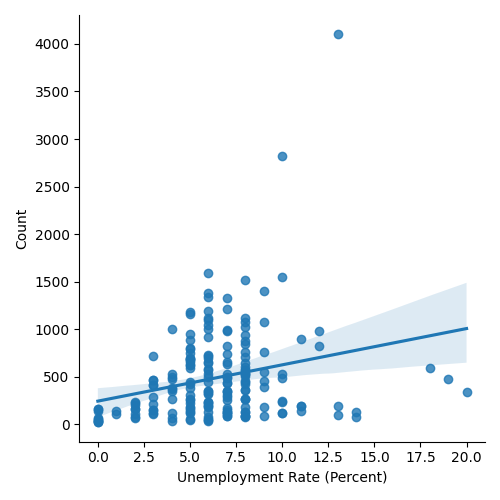

(38.165016407918124, 243.77079777854084, 625.4209618577227)

In [56]:
plot_regression(x="Unemployment Rate", y="Count", data=combined_df, xunit="Percent")

There's a positive correlation between the unemployment rate and the number of events.

In [119]:
combined_df[combined_df["Unemployment Rate"] > 0.1]

,Count,Boundary Type,Boundary Name,Population 2016,Population Density 2016,Year opened,Aboriginal,Aboriginal Percent,Visible Minorities Numbers,Visible Minorities Percent,...,Own vs Rent Percent,Bad Dwelling,Bad Dwelling Percent,Average and Median Household Income,Commuting Method,Commuting Method Percent,LIM-AT,LICO-AT,Average Household Income,Median Household Income
51,79,Neighbourhood,Edgeland,1255,4638.596076,1971,160,0.127490,"[10, 10, 125, 10, 0, 0, 25, 0, 60, 0, 25, 55]","[0.03125, 0.03125, 0.390625, 0.03125, 0, 0, 0....",...,"[0.4126984126984127, 0.5873015873015873]",60,0.096000,"[79064, 51763]","[215, 105]","[0.671875, 0.328125]",0.438247,0.306773,79064,51763
62,94,Neighbourhood,China Town,420,6364.311366,1986,0,0.000000,"[25, 30, 0, 310, 15, 0, 25, 0, 0, 0, 0, 0]","[0.06172839506172839, 0.07407407407407407, 0, ...",...,"[0, 1]",15,0.081081,"[32142, 22886]","[35, 85]","[0.2916666666666667, 0.7083333333333334]",0.571429,0.321429,32142,22886
78,129,Neighbourhood,Pembina Strip,3175,4444.313798,1971,150,0.047244,"[145, 635, 230, 390, 30, 15, 105, 45, 100, 0, ...","[0.08454810495626822, 0.37026239067055394, 0.1...",...,"[0.19287833827893175, 0.8071216617210683]",80,0.047478,"[43921, 38914]","[760, 660]","[0.5352112676056338, 0.46478873239436613]",0.382677,0.324409,43921,38914
83,136,Neighbourhood,St. John's Park,530,1318.037467,1971,150,0.283019,"[0, 0, 45, 0, 10, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0.8181818181818182, 0, 0.18181818181818...",...,"[0.5686274509803921, 0.43137254901960786]",25,0.100000,"[58337, 40872]","[160, 75]","[0.6808510638297872, 0.3191489361702128]",0.452830,0.386792,58337,40872
101,188,Neighbourhood,Rosser-Old Kildonan,680,42.511717,1971,50,0.073529,"[305, 110, 0, 0, 0, 15, 0, 0, 0, 10, 0, 0]","[0.6931818181818182, 0.25, 0, 0, 0, 0.03409090...",...,"[0.9487179487179487, 0.05128205128205128]",0,0.000000,"[121020, 94781]","[290, 85]","[0.7733333333333333, 0.22666666666666668]",0.125926,0.125926,121020,94781
103,191,Neighbourhood,Montcalm,4940,4371.190141,1971,400,0.080972,"[80, 790, 725, 830, 65, 25, 85, 90, 130, 10, 7...","[0.027303754266211604, 0.2696245733788396, 0.2...",...,"[0.09898989898989899, 0.901010101010101]",140,0.056566,"[44955, 39030]","[1075, 1040]","[0.508274231678487, 0.49172576832151305]",0.403242,0.362715,44955,39030
104,193,Neighbourhood,South Point Douglas,390,562.596832,1971,205,0.525641,"[0, 0, 25, 0, 10, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0.7142857142857143, 0, 0.28571428571428...",...,"[0.11764705882352941, 0.8823529411764706]",10,0.058824,"[59433, 50578]","[90, 65]","[0.5806451612903226, 0.41935483870967744]",0.397436,0.320513,59433,50578
129,339,Neighbourhood,Lord Selkirk Park,1520,2843.327067,1971,975,0.641447,"[10, 0, 175, 10, 10, 0, 0, 0, 0, 0, 0, 10]","[0.046511627906976744, 0, 0.813953488372093, 0...",...,"[0.09448818897637795, 0.905511811023622]",50,0.078125,"[28570, 20047]","[90, 145]","[0.3829787234042553, 0.6170212765957447]",0.704918,0.560656,28570,20047
157,481,Neighbourhood,Centennial,2830,5312.149806,1971,955,0.337456,"[365, 70, 420, 140, 190, 35, 160, 10, 10, 0, 2...","[0.25704225352112675, 0.04929577464788732, 0.2...",...,"[0.20772946859903382, 0.7922705314009661]",180,0.175610,"[39134, 29635]","[270, 420]","[0.391304347826087, 0.6086956521739131]",0.592920,0.467257,39134,29635
176,589,Neighbourhood,Dufferin,2255,3452.103027,1971,935,0.414634,"[370, 55, 85, 10, 15, 20, 60, 0, 0, 0, 0, 0]","[0.6016260162601627, 0.08943089430894309, 0.13...",...,"[0.30952380952380953, 0.6904761904761905]",110,0.130952,"[38693, 31376]","[260, 315]","[0.45217391304347826, 0.5478260869565217]",0.547672,0.467849,38693,31376


For neighbourhoods with unemployment rate > 10%, the education level is much lower. For example, both China Town and Lord Selkirk Park have more than half of people doesn't have a high school diploma or other higher education.

In [120]:
combined_df.groupby("Year opened").count()

,Count,Boundary Type,Boundary Name,Population 2016,Population Density 2016,Aboriginal,Aboriginal Percent,Visible Minorities Numbers,Visible Minorities Percent,Visible Minorities Total Number,...,Own vs Rent Percent,Bad Dwelling,Bad Dwelling Percent,Average and Median Household Income,Commuting Method,Commuting Method Percent,LIM-AT,LICO-AT,Average Household Income,Median Household Income
Year opened,,,,,,,,,,,,,,,,,,,,,
1971,158,158,158,158,158,158,158,158,158,158,...,158,158,158,158,158,158,158,158,158,158
1976,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1981,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1986,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
1991,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2001,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2006,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2011,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2016,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


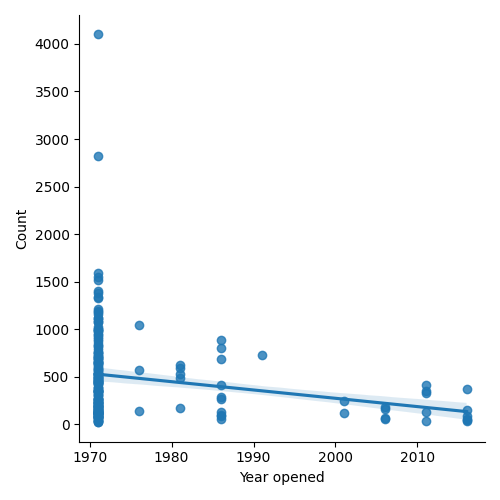

In [121]:
# combined_df.plot(kind="scatter", x="Year opened", y="Count")
# sns.lmplot(x="Year opened", y="Count", data=combined_df).set_xticklabels([1971, 1976, 1981, 1986, 1991, 2001, 2006, 2011, 2016])
# plt.show()
sns.lmplot(x="Year opened", y="Count", data=combined_df)
# sns.lmplot(x="Year opened", y="Count", data=combined_df, x_estimator=np.mean)
plt.show()

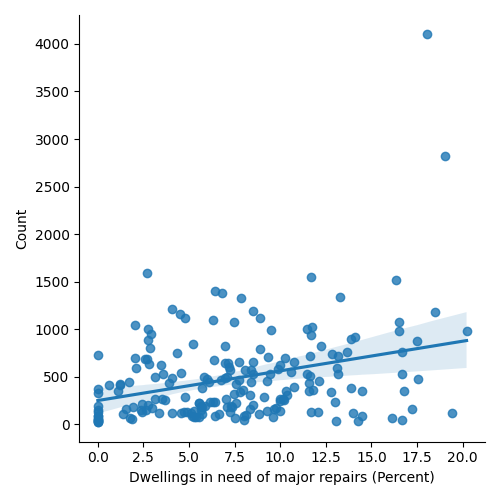

(31.183543255357684, 250.2520954489658, 565.4955655167889)

In [122]:
# combined_df.plot(kind="scatter", x="Bad Dwelling Percent", y="Count")
plot_regression(x="Bad Dwelling Percent", y="Count", data=combined_df, xlables="Dwellings in need of major repairs", xpercent=True)

There is a positive correlation between the proportion of bad dwelling and the number of events.

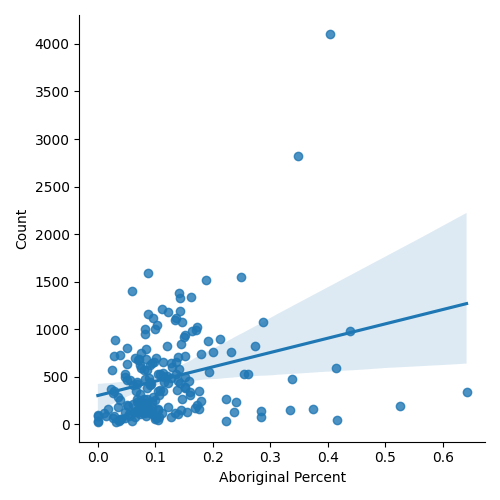

In [123]:
# combined_df.plot(kind="scatter", x="Aboriginal Percent", y="Count")
sns.lmplot(x="Aboriginal Percent", y="Count", data=combined_df)
plt.show()

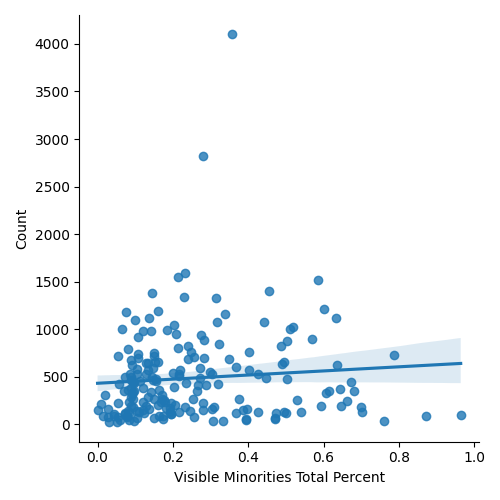

In [124]:
# combined_df.plot(kind="scatter", x="Visible Minorities Total Percent", y="Count")
sns.lmplot(x="Visible Minorities Total Percent", y="Count", data=combined_df)
plt.show()

In [50]:
combined_df['No Education'] = combined_df['Education Percent'].str.strip("[]").str.split(', ').str[0]
combined_df['High School Education'] = combined_df['Education Percent'].str.strip("[]").str.split(', ').str[1]
combined_df['Undergraduate Education'] = combined_df['Education Percent'].str.strip("[]").str.split(', ').str[2]

combined_df['No Education'] = combined_df['No Education'].astype(float)
combined_df['High School Education'] = combined_df['High School Education'].astype(float)
combined_df['Undergraduate Education'] = combined_df['Undergraduate Education'].astype(float)

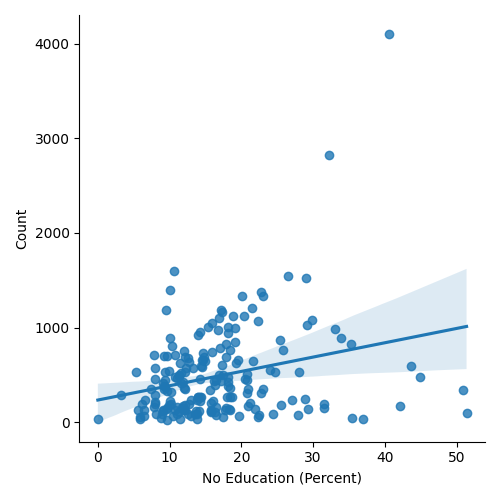

(15.141894323192869, 233.59968128185986, 622.6622437527883)

In [52]:
plot_regression(x="No Education", y="Count", data=combined_df, xpercent=True)

This confirms what we had before, poor education have a positive correlation with the number of events.

In [127]:
combined_df['Non Citizenship Percent'] = combined_df['Citizenship Percent'].str.strip("[]").str.split(', ').str[1].astype(float)

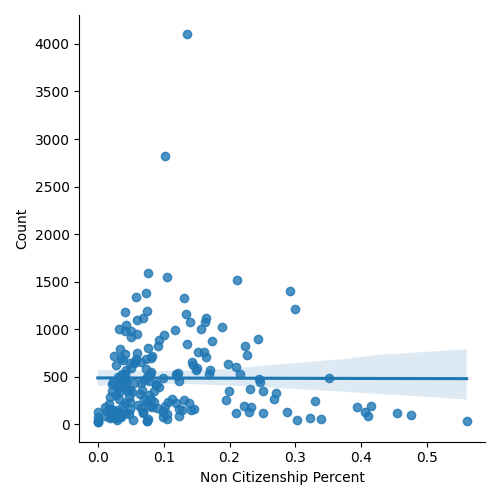

In [128]:
# combined_df.plot(kind="scatter", x="Non Citizenship Percent", y="Count")
sns.lmplot(x="Non Citizenship Percent", y="Count", data=combined_df)
plt.show()

In [6]:
combined_df['House'] = combined_df['Household Type'].str.strip("[]").str.split(', ').str[0].astype(int)
combined_df['Apartment'] = combined_df['Household Type'].str.strip("[]").str.split(', ').str[1].astype(int)
combined_df['Other'] = combined_df['Household Type'].str.strip("[]").str.split(', ').str[2].astype(int)

In [26]:
combined_df['Household sum']  = combined_df['Household Type'].str.strip("[]").str.split(', ').str[0].astype(int)
combined_df['Household sum'] += combined_df['Household Type'].str.strip("[]").str.split(', ').str[1].astype(int)
combined_df['Household sum'] += combined_df['Household Type'].str.strip("[]").str.split(', ').str[2].astype(int)
combined_df['House Ratio'] = combined_df['House']/combined_df['Household sum']
combined_df['Apartment Ratio'] = combined_df['Apartment']/combined_df['Household sum']

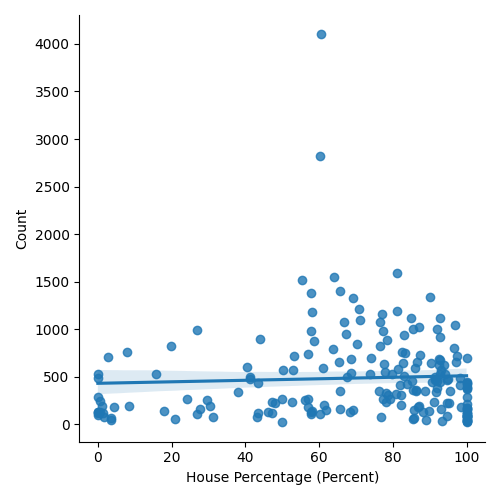

(0.794505212447362, 431.2314301800046, 470.95669080237263)

In [34]:
plot_regression(x='House Ratio', y="Count", data=combined_df, xlables="House Percentage", xpercent=True)

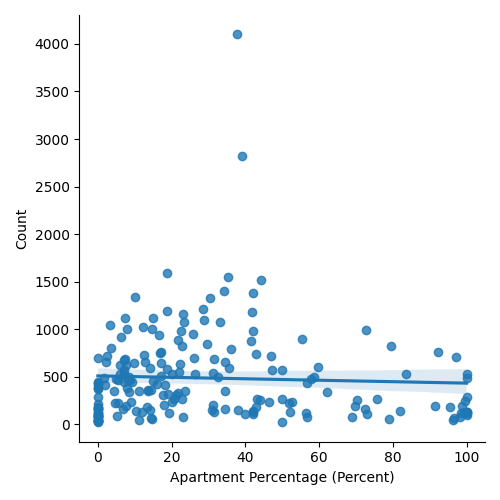

(-0.7636342544947983, 509.41760645386637, 471.23589372912653)

In [35]:
plot_regression(x="Apartment Ratio", y="Count", data=combined_df, xlables="Apartment Percentage", xpercent=True)

In [134]:
combined_df['Rent Percent'] = combined_df['Own vs Rent Percent'].str.strip("[]").str.split(', ').str[1].astype(float)

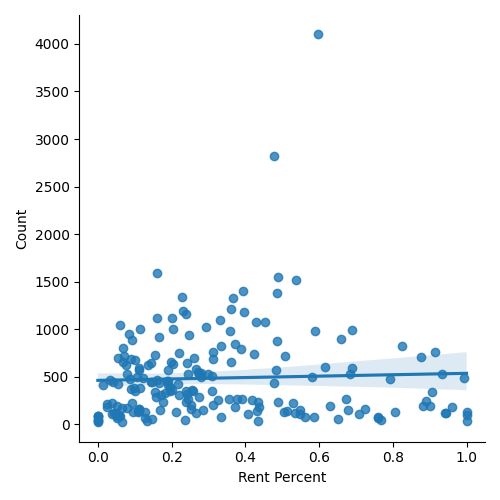

In [135]:
# combined_df.plot(kind="scatter", x="Rent Percent", y="Count")
sns.lmplot(x="Rent Percent", y="Count", data=combined_df)
plt.show()

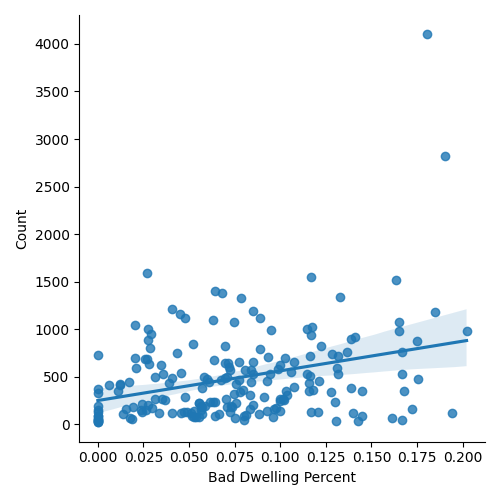

In [136]:
# combined_df.plot(kind="scatter", x="Bad Dwelling Percent", y="Count")
sns.lmplot(x="Bad Dwelling Percent", y="Count", data=combined_df)
# plot_regression(x="Bad Dwelling Percent", y="Count", data=combined_df, xlables="Dwellings in need of major repairs", xpercent=True)
plt.show()

In [39]:
combined_df['Private Commuting Percent'] = combined_df['Commuting Method Percent'].str.strip("[]").str.split(', ').str[0].astype(float)
combined_df['Public Commuting Percent'] = combined_df['Commuting Method Percent'].str.strip("[]").str.split(', ').str[1].astype(float)

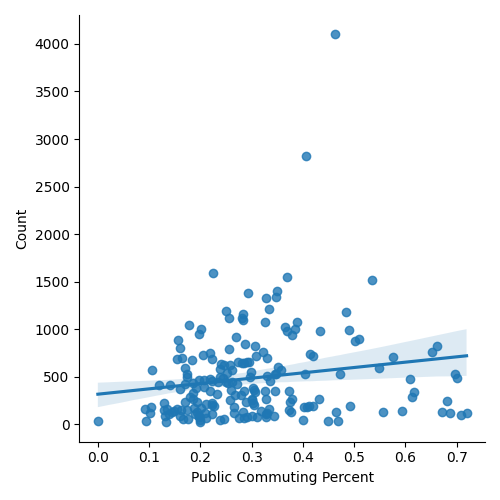

In [138]:
# combined_df.plot(kind="scatter", x="Public Commuting Percent", y="Count")
sns.lmplot(x="Public Commuting Percent", y="Count", data=combined_df)
plt.show()

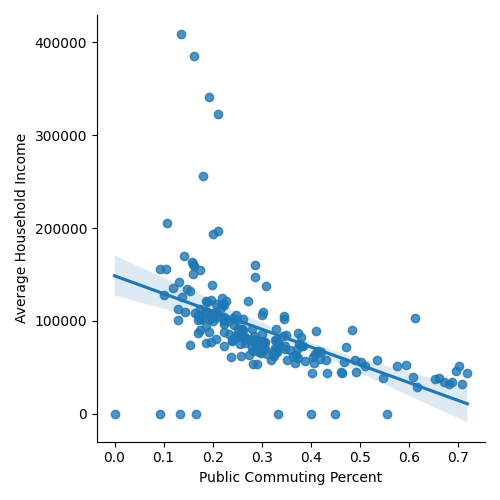

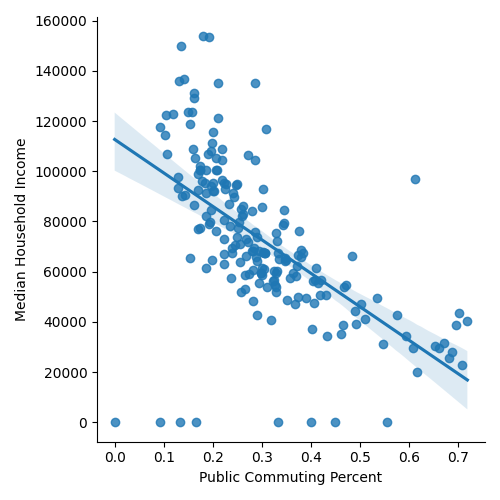

(-133106.3269491872, 112659.67672230757, 64773.86397839261)

In [47]:
plot_regression(x="Public Commuting Percent", y="Average Household Income", data=combined_df, xpercent=True)
plot_regression(x="Public Commuting Percent", y="Median Household Income", data=combined_df, xpercent=True)


In [141]:
high_poverty_low_reports = combined_df[combined_df["LIM-AT"] > 0.2][combined_df["Count"] < 100]

C:\Users\tommy\AppData\Local\Temp\ipykernel_22896\868849869.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_poverty_low_reports = combined_df[combined_df["LIM-AT"] > 0.2][combined_df["Count"] < 100]


These neighbourhoods

## TODO: Find which service request is more likely to be reported in high poverty areas?

c:\Users\tommy\GitHub\winnipeg-311-data-analysis\venv\Lib\site-packages\seaborn\axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


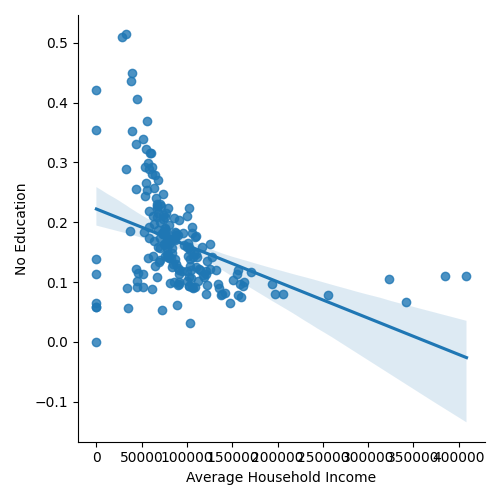

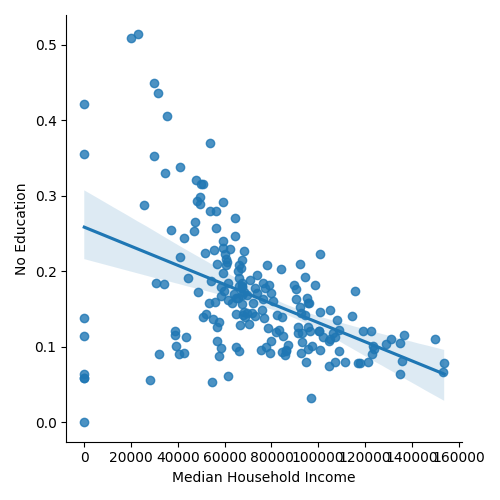

In [142]:
sns.lmplot(x="Average Household Income", y="No Education", data=combined_df)
plt.show()
sns.lmplot(x="Median Household Income", y="No Education", data=combined_df)
plt.show()

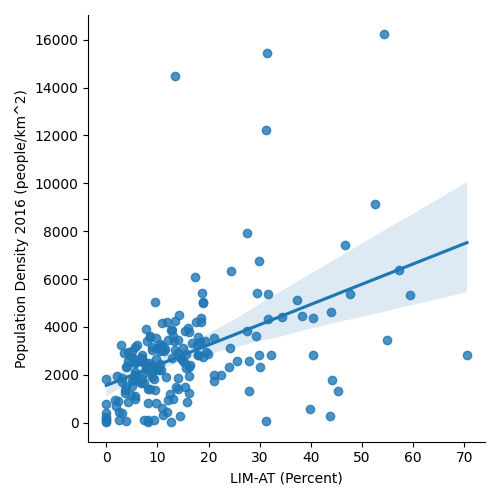

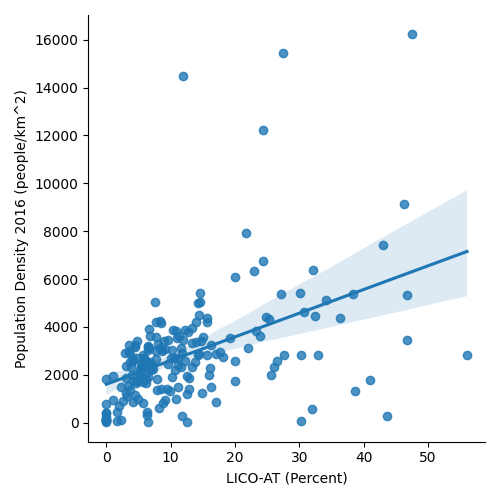

((84.61824361240832, 1555.9321514500805, 4538.378442707094),
 (98.93609482694235, 1604.233434623326, 4377.6878961654775))

In [53]:
(plot_regression(x="LIM-AT", y="Population Density 2016", data=combined_df, xpercent=True, yunit="people/km^2"), 
plot_regression(x="LICO-AT", y="Population Density 2016", data=combined_df, xpercent=True, yunit="people/km^2"))

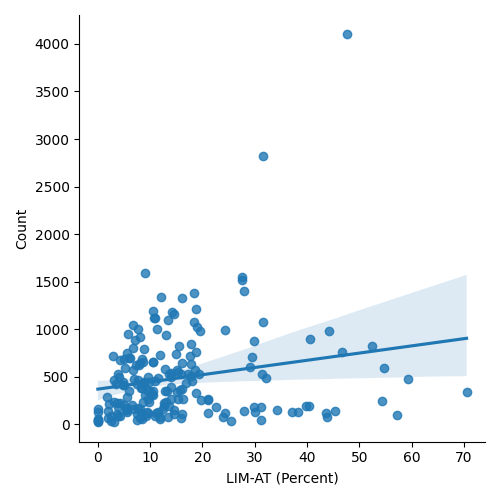

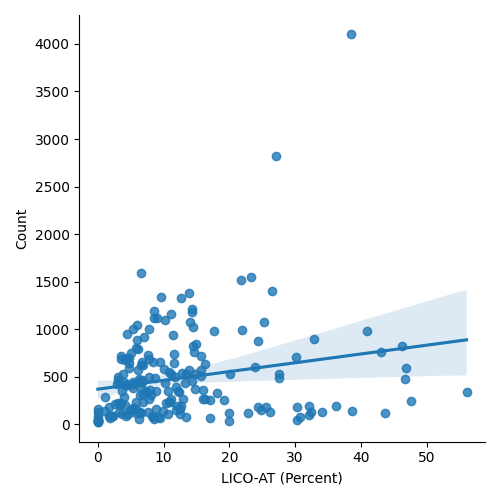

((7.578618068910166, 370.1608322768499, 637.2760592958144),
 (9.250543263381019, 369.5692660555652, 628.8877739306722))

In [144]:
(plot_regression(x="LIM-AT", y="Count", data=combined_df, xpercent=True),
plot_regression(x="LICO-AT", y="Count", data=combined_df, xpercent=True))

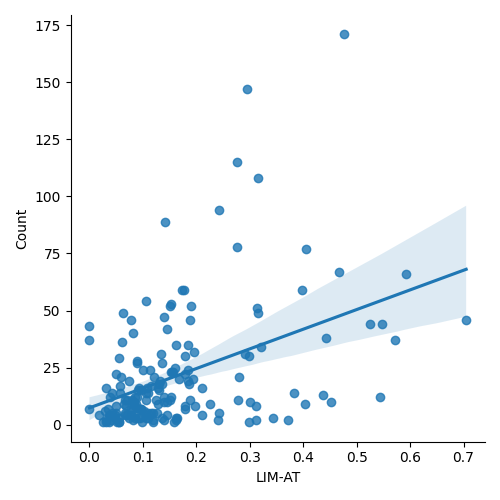

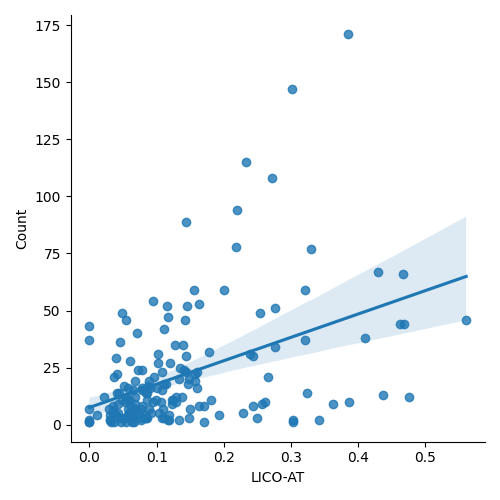

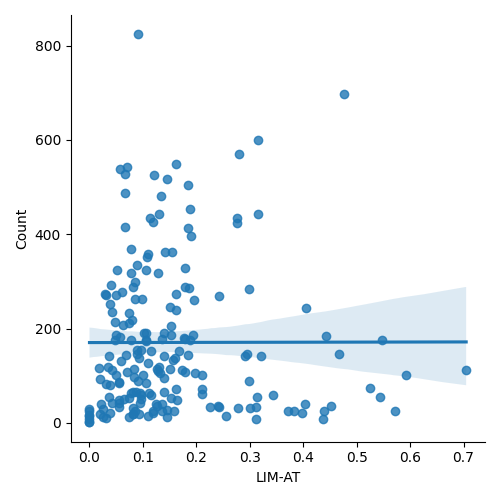

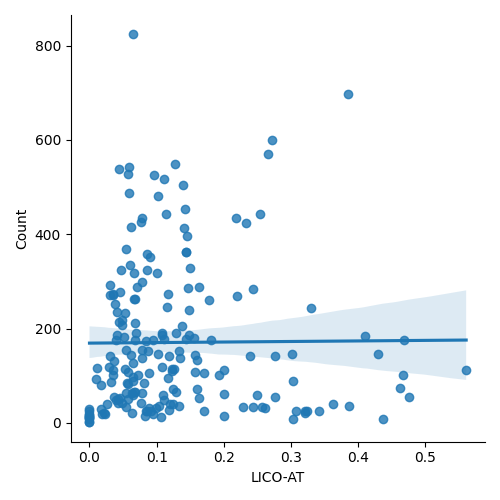

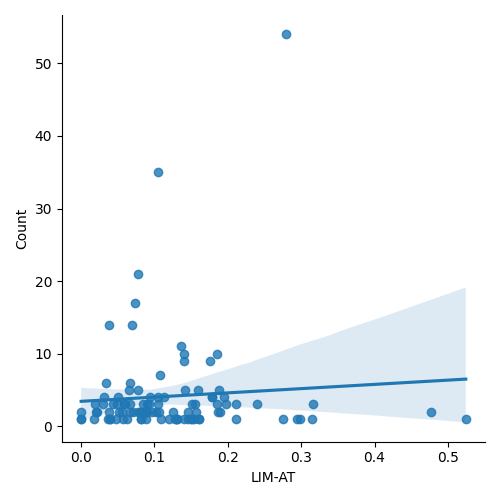

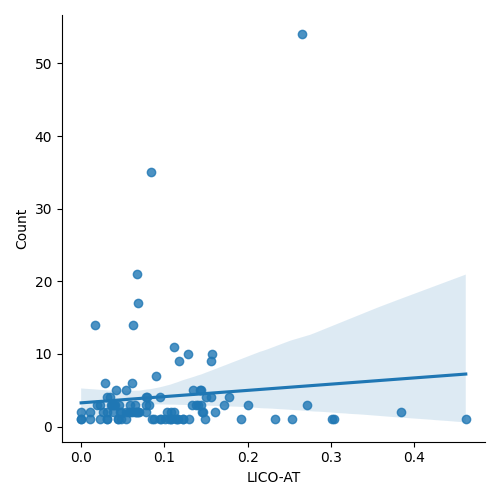

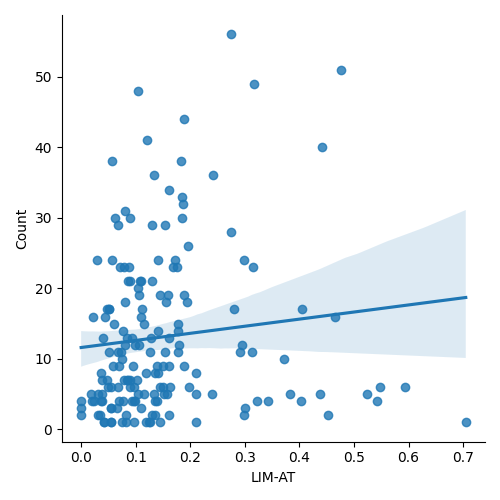

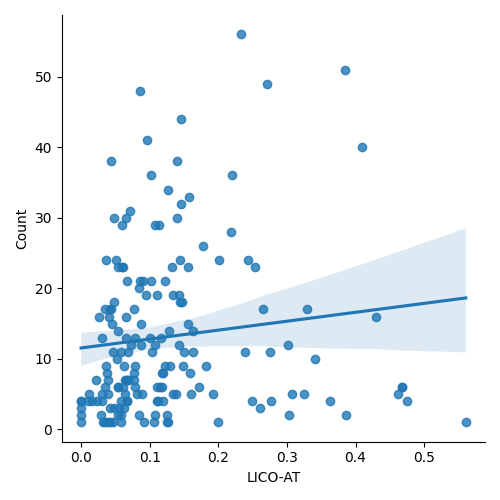

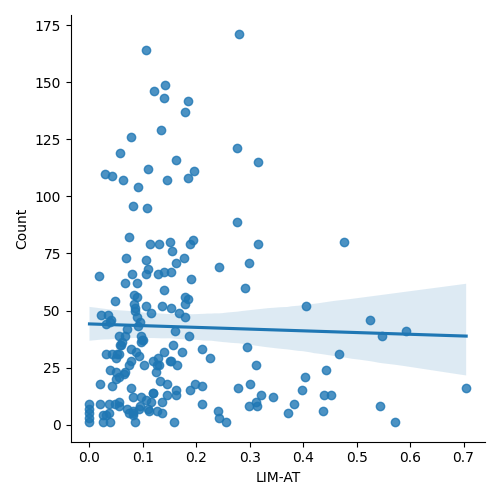

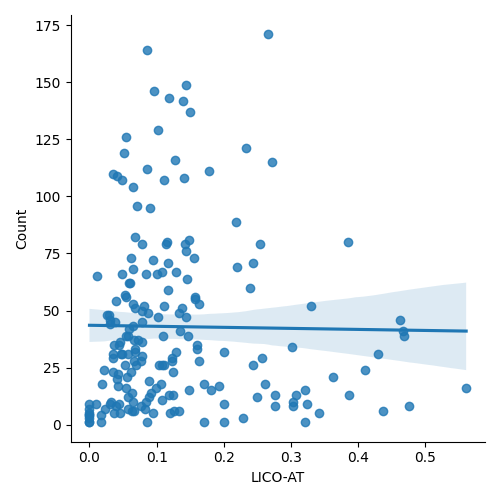

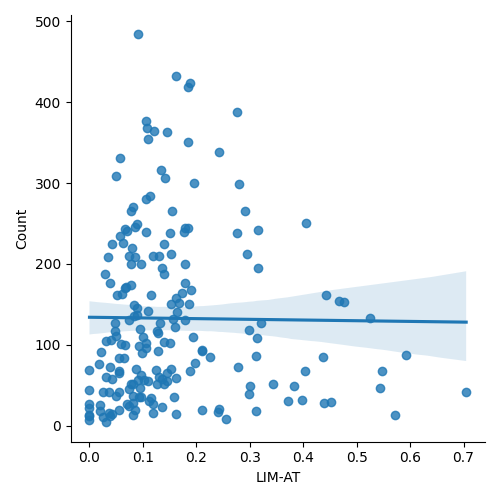

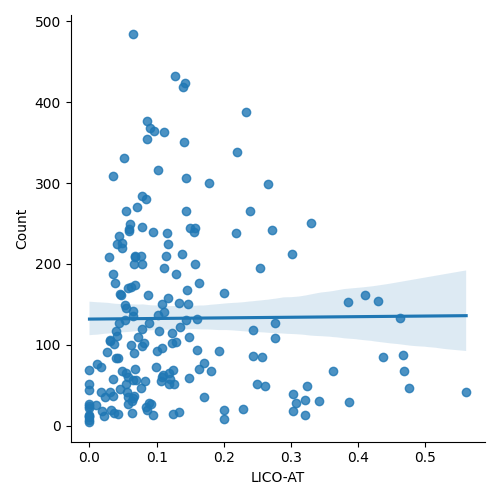

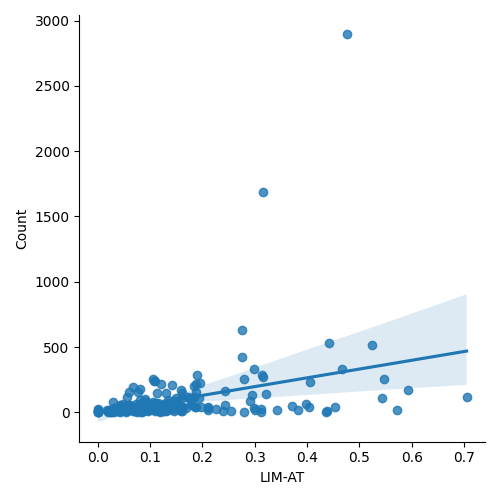

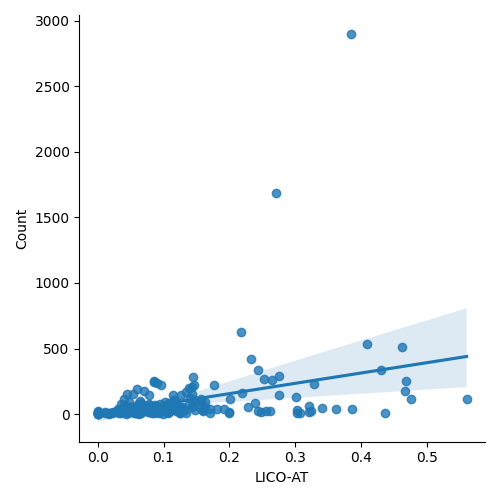

In [146]:
#           graffiti, garbage,  insect,   Dog,  water,    snow
for srv in [[4],     [5, 6, 7], [8, 16], [1],  [12, 17], [2, 10, 11, 14, 15], [9]]:
    combined_df = make_df(srv)
    sns.lmplot(x="LIM-AT", y="Count", data=combined_df)
    plt.show()
    sns.lmplot(x="LICO-AT", y="Count", data=combined_df)
    plt.show()